In [82]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_validate, GridSearchCV

In [5]:
df = pd.read_csv('demo_sales.csv')
df.tail()

,Date,Units,Sales
1088,27/12/2022,7114,22551.38
1089,28/12/2022,7759,24596.03
1090,29/12/2022,6457,20468.69
1091,30/12/2022,7284,23090.28
1092,31/12/2022,0,0.00


### Create features

In [ ]:
target_map = data['sales'].to_dict()

data['lag1'] = (data['date'] - pd.Timedelta('364 days')).map(target_map)
data['lag2'] = (data['date'] - pd.Timedelta('728 days')).map(target_map)
data['lag3'] = (data['date'] - pd.Timedelta('1092 days')).map(target_map)

In [ ]:
# Convert dates to datetime format
df['Date'] = pd.to_datetime(df['Date'], 
#               errors='ignore', 
                format='%d/%m/%Y',
                dayfirst=True)
df.tail()

,Date,Units,Sales
1088,2022-12-27,7114,22551.38
1089,2022-12-28,7759,24596.03
1090,2022-12-29,6457,20468.69
1091,2022-12-30,7284,23090.28
1092,2022-12-31,0,0.00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1093 non-null   datetime64[ns]
 1   Units   1093 non-null   int64         
 2   Sales   1093 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 25.7 KB


In [8]:
X = df.drop(['Units', 'Sales'], axis=1)
y = df['Units']
X

,Date
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05
...,...
1088,2022-12-27
1089,2022-12-28
1090,2022-12-29
1091,2022-12-30


### Preprocess

In [ ]:

num_features = X

preprocessor = ColumnTransformer(
    [
        ('StandardScaler', StandardScaler(), num_features),
    ]
) 

In [ ]:
X = preprocessor.fit_transform()

### Evaluate models

In [ ]:
def evaluate_model(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

NameError: name 'LinearRegression' is not defined

In [ ]:
models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'XGBRegressor': XGBRegressor()
}

model_list = []
r2_list = []
rmse_list = []
results = []
param_grid = {'': [0, 1]}


for model_name, model in models.items():
    time_series_split = TimeSeriesSplit(n_splits=6)
    cv_scores = cross_validate(model, X, y, cv=time_series_split)
    #cv_results = cross_val_score(model, X_train, y_train, cv=cv)
    
    # Fine tune hyperparams
    gs = GridSearchCV(model, cv=time_series_split, param_grid=param_grid)
    gs.fit(X, y)
    results.append(cv_scores['test_score'].mean())

    #train_rmse, train_r2 = evaluate_model() # ???
    #y_pred_test = model.predict(X_test)
    #test_rmse, test_r2 = evaluate_model(y_test, y_pred_test)
    print(model_name)
    print('Model performance for Training set')
    print(f'- RMSE: {train_rmse}')
    print(f'- R2: {train_r2}')
    print('-----------------------------')
    print('Model performance for Test set')
    print(f'- RMSE: {test_rmse}')
    print(f'- R2: {test_r2}')

plt.boxplot(results, labels=models.keys())
plt.show()

In [ ]:
# Need to encode date somehow to pass to X

# Create lag features

In [56]:
import numpy as np
import xgboost as xgb
#para = param[LinearRegression()]
# or this, not sure 
param_grid = {'learning_rate': [0.01, 0.1, 0.2, 0.3],
              'n_estimators': [100,200,400]
}
X1 = y.shift(1)
time_series_split = TimeSeriesSplit(test_size=90)


#model = LinearRegression()
model = XGBRegressor(random_state=1)
#xgb.DMatrix()
# Perform randomized grid search on train data and find best params
gs = GridSearchCV(model, param_grid, cv=time_series_split, scoring='neg_root_mean_squared_error')
gs.fit(X1, y)

print("Best CV score: ", np.abs(gs.best_score_))

#model.set_params(**gs.best_params_)
#gs.best_score_

#cv_scores = cross_validate(model, X, y, cv=time_series_split)
#print("CV score: ", cv_scores['test_score'].mean())

Best CV score:  2251.838330078125


In [58]:
gs.best_params_

{'learning_rate': 0.01, 'n_estimators': 100}

In [ ]:
# Fit best parameters to model and train it on full data to make real predictions
final_model = XGBRegressor(**gs.best_params)
final_model.fit(X1)
predictions = final_model.predict(*unseen dates*)

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [1]:
import numpy as np
print(np.__version__)

1.26.4


In [2]:
import pmdarima

In [9]:
def check_stationarity(data):
    result = adfuller(data, autolag='AIC')
    p_value = result[1]
    print(f'p-value is {round(p_value, 3)}' + ' => ' + 'Stationary' if p_value < 0.05 else 'Non-stationary')

check_stationarity(y)

p-value is 0.0 => Stationary


Time-series is stationary, therefore we **can** apply SARIMA

In [76]:
X_train = df[['Date','Units']][:-90].set_index('Date')
X_test = df[['Date','Units']][-90:].set_index('Date')
y_train = y[:-90]
y_test = y[-90:]
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12
model = SARIMAX(X_train, order=(p,d,q), seasonal_order=(P,D,Q,s))
trained_model = model.fit()

forecast = trained_model.get_forecast(steps=90)


c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is a

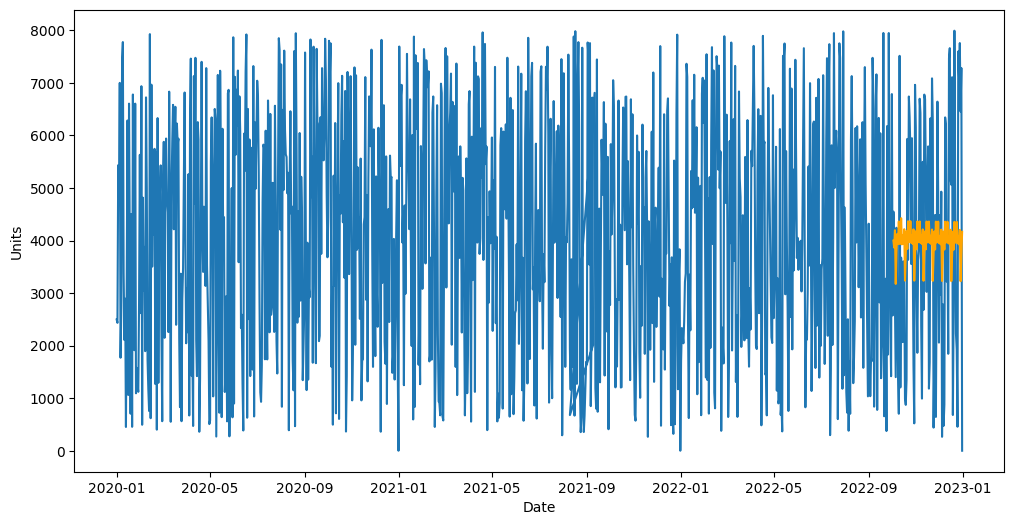

In [82]:
import matplotlib.pyplot as plt
all_data = df[['Date','Units']].set_index('Date')
plt.figure(figsize=(12,6))
plt.plot(all_data, label='Observed')
plt.plot(X_test.index, forecast.predicted_mean, label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Units')
plt.show()

The model is quite bad, need to fine-tune it

In [ ]:
param_grid = {'p': [0,1],
              'd': [0,1],
              'q': [0,1],
              'P': [0,1],
              'D': [0,1],
              'Q': [0,1],
              's': [12]
              }

time_series_split = TimeSeriesSplit(test_size=90)
# idk how to perform gridsearch on sarima model, the model wants data as mandatory input and it contradicts the GS func params
model = SARIMAX(time_series_split)
gs = GridSearchCV(model, param_grid, cv=time_series_split, scoring='neg_root_mean_squared_error')
gs.fit(X_train.index, X_train)

TypeError: object of type 'TimeSeriesSplit' has no len()

In [ ]:
final_model = SARIMAX(**gs.best_params)
final_model.fit()
forecast1 = final_model.get_forecast(steps=90)

1003    3998.449101
1004    3866.399832
1005    4196.835878
1006    3174.777798
1007    3791.256789
           ...     
1088    3925.895877
1089    4203.734368
1090    3226.262258
1091    3719.454801
1092    4166.152706
Name: predicted_mean, Length: 90, dtype: float64

In [10]:
from pmdarima import auto_arima

train = df[['Date','Units']][:-90].set_index('Date')
test = df[['Date','Units']][-90:].set_index('Date')
#y_train = y[:-90]
#y_test = y[-90:]
sarima = auto_arima(train, seasonal=True, m=7)
predictions = sarima.predict(n_periods=len(test))
rmse = root_mean_squared_error(test, predictions)
print('RMSE: ', rmse)

c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecast

RMSE:  2307.8549952192357


c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


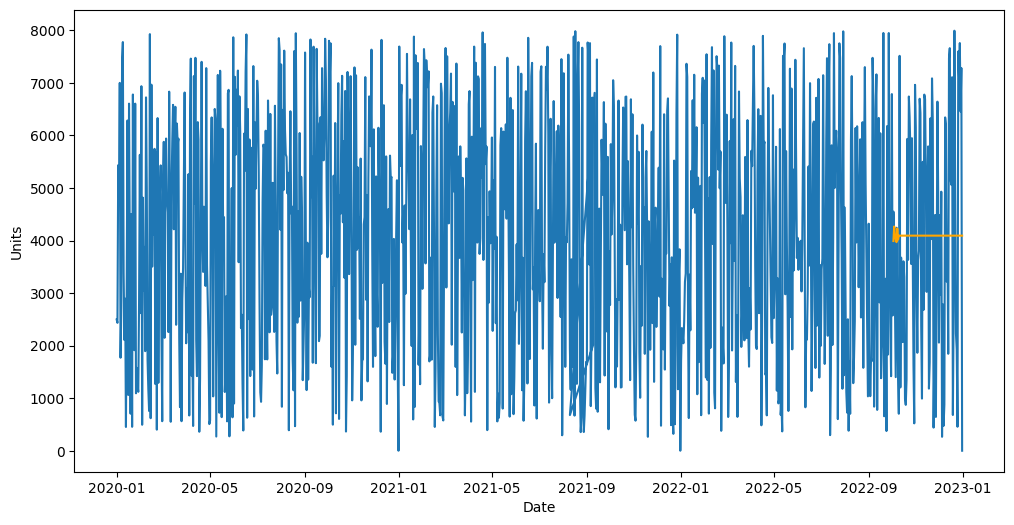

In [22]:
import matplotlib.pyplot as plt

def plot_predictions(test, predictions):
    all_data = df[['Date','Units']].set_index('Date')
    plt.figure(figsize=(12,6))
    plt.plot(all_data, label='Observed')
    plt.plot(test.index, predictions, label='Forecast', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Units')
    plt.show()

plot_predictions(test, predictions)

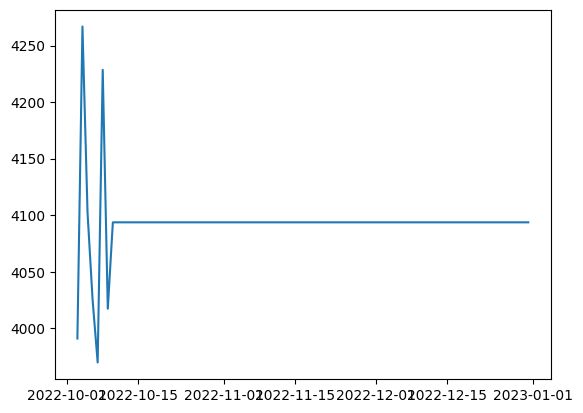

In [15]:
plt.plot(test.index, predictions)

In [20]:
from sklearn.model_selection import cross_val_score, ParameterGrid

rmse = []
grid = {'p': [0,1],
        'd': [0,1],
        'q': [0,1],
        'P': [0,1],
        'D': [0,1],
        'Q': [0,1],
        }
param_grid = ParameterGrid(grid)

for params in param_grid:
    # Model
    model = pmdarima.ARIMA(order = (params['p'],params['d'],params['q']),
                           seasonal_order = (params['P'],params['D'],params['Q'], 7),
                           suppress_warnings = True,
                           force_stationarity = False
                           )
    # CV
    cv_split = TimeSeriesSplit(test_size=90)
    cv_score = cross_val_score(model,
                               X = train.index,
                               y = train,
                               scoring = 'neg_mean_squared_error',
                               cv = cv_split
                               )
    # Error
    error = np.sqrt(np.average(cv_score))
    rmse.append(error)



c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-package

KeyboardInterrupt: 

In [ ]:
tuning_results = pd.DataFrame(param_grid)
tuning_results['rmse'] = rmse
best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
print(best_params)

In [36]:
# Fine-tuning SARIMA with auto_arima
sarima = auto_arima(train, 
                    start_p = 0,
                    d = 0,
                    start_q = 0,
                    max_p = 500,
                    max_q = 500,
                    start_P = 0,
                    D = 0,
                    start_Q = 0,
                    max_P = 1, 
                    max_Q = 1,
                    seasonal = True, 
                    m = 7,
                    random_state = 1,
                    suppress_warnings = True)
predictions = sarima.predict(n_periods=len(test))
rmse = root_mean_squared_error(test, predictions)
print('RMSE: ', rmse)

c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vector\Documents\GitHub\Demand-Forecast

RMSE:  2307.8549952192357


c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


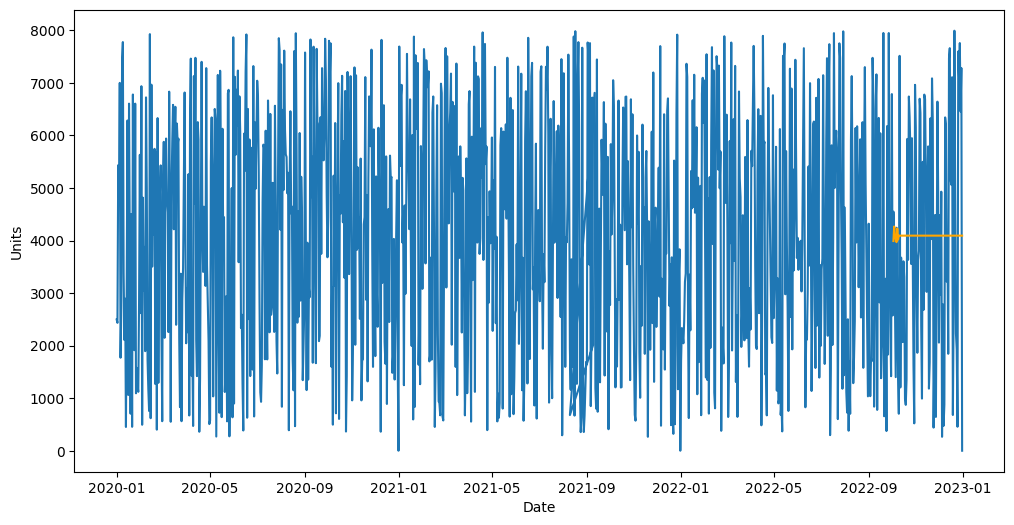

In [37]:
plot_predictions(test, predictions)

In [ ]:
sarima.summary()

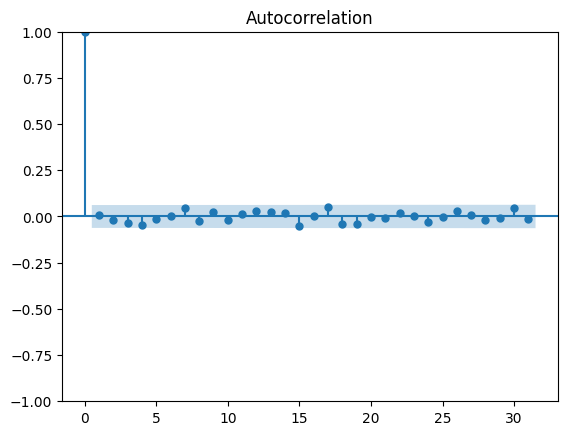

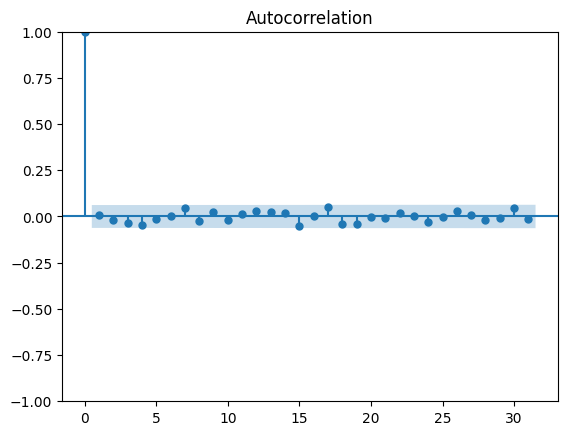

In [ ]:
import statsmodels.api as st
st.graphics.tsa.plot_acf(train)

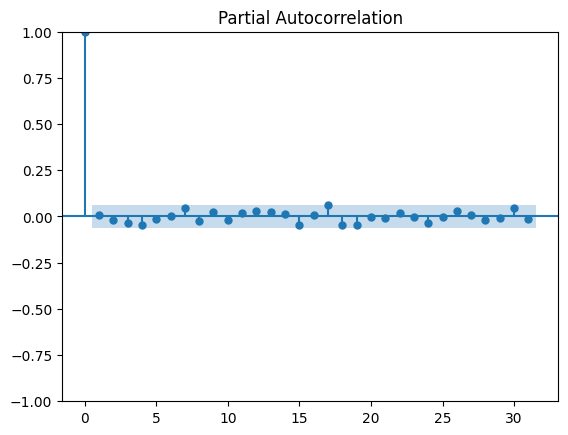

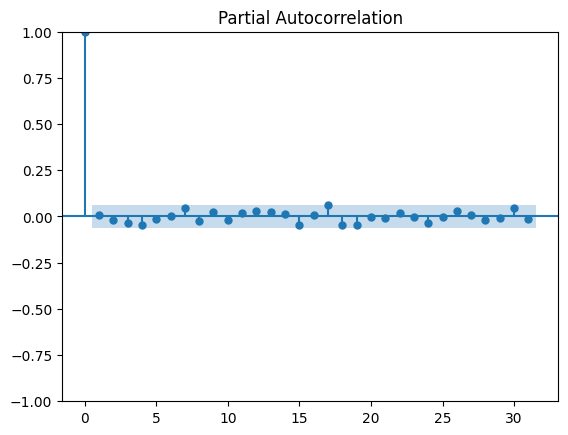

In [31]:
st.graphics.tsa.plot_pacf(train)

In [38]:
# Data doesn't have autocorrelations. => What then?
# Gotta try to fine-tune values for SARIMA from auto_arima. 
# Try to find diff data

In [80]:
import operator
report = {
          '1': ('model1', 353),
          '2': ('model2', 796),
          '3': ('model3', 80),
          '4': ('model4', 801),
          '5': ('model5', 55),
}
# Get best model and best score
best_model = max(report.items(), key=lambda v: v[1][1])[0]
#best_model_score = min(report.items(), key=operator.itemgetter(1))[1]
best_model_score = max(report.items(), key=lambda v: v[1][1])[1][1]
print('best_model: ', best_model)
print('best_model_score: ', best_model_score)

best_model:  4
best_model_score:  801


In [102]:
from sklearn.model_selection import TimeSeriesSplit
all_data2 = pd.read_csv('demo_sales.csv')
all_data2['Date'] = pd.to_datetime(all_data2['Date'], 
                format='%d/%m/%Y',
                dayfirst=True)
time_series_split = TimeSeriesSplit(test_size=90)
for train_idx, test_idx in time_series_split.split(all_data2[['Date','Units']].set_index('Date')):
    #print('train idx: ',train_idx)
    #print('test idx: ',test_idx)
    X_train, X_test = all_data2.iloc[train_idx], all_data2.iloc[test_idx]
    #print(f"X_train: {X_train}, X_test: {X_test}\n")
    print(test_idx)

[643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660
 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678
 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696
 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714
 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732]
[733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749 750
 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767 768
 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786
 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804
 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822]
[823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840
 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858
 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876
 877 878 879 880 881 882 883 884 885 886 887 888 

In [98]:
X_test

,Date,Units,Sales
1003,2022-10-03,4551,14426.67
1004,2022-10-04,4161,13190.37
1005,2022-10-05,2711,8593.87
1006,2022-10-06,1401,4441.17
1007,2022-10-07,4244,13453.48
...,...,...,...
1088,2022-12-27,7114,22551.38
1089,2022-12-28,7759,24596.03
1090,2022-12-29,6457,20468.69
1091,2022-12-30,7284,23090.28
